In [2]:
# analysis.ipynb

"""
Analysis Script
Author: Imran Feisal
Date: 31/10/2024
Description:
This Jupyter notebook performs clustering and visualization on the latent features
and TabNet predictions, uses advanced clustering methods to determine the optimal
number of clusters, and provides in-depth analysis.

Inspiration:
- Xu, Y., Goodacre, S., & Hall, M. (2018). Developing a Dynamic Health Index Using Machine Learning to Predict Patient Deterioration. IEEE Journal of Biomedical and Health Informatics, 22(3), 919-925.
- McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv preprint arXiv:1802.03426.
"""

'\nAnalysis Script\nAuthor: Imran Feisal\nDate: 31/10/2024\nDescription:\nThis Jupyter notebook performs clustering and visualization on the latent features\nand TabNet predictions, uses advanced clustering methods to determine the optimal\nnumber of clusters, and provides in-depth analysis.\n\nInspiration:\n- Xu, Y., Goodacre, S., & Hall, M. (2018). Developing a Dynamic Health Index Using Machine Learning to Predict Patient Deterioration. IEEE Journal of Biomedical and Health Informatics, 22(3), 919-925.\n- McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv preprint arXiv:1802.03426.\n'


# Import necessary libraries

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import umap.umap_ as umap
from scipy.stats import f_oneway, kruskal
import warnings
warnings.filterwarnings('ignore')


# Set random seed for reproducibility

In [4]:
np.random.seed(42)

In [5]:
# Load latent features from VAE
latent_features = pd.read_csv('latent_features_vae.csv')

# Load TabNet predictions
tabnet_predictions = pd.read_csv('tabnet_predictions.csv')

# Merge data
data = latent_features.merge(tabnet_predictions, on='Id', how='inner')

# Extract the features for clustering (exclude 'Id' and 'Predicted_Health_Index')
X = data.drop(columns=['Id', 'Predicted_Health_Index'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

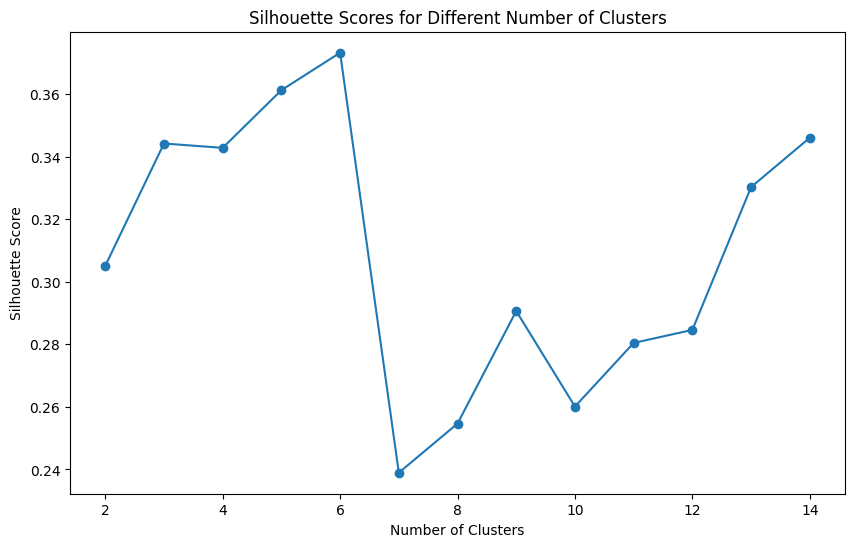

In [6]:
# Determine optimal number of clusters using Silhouette Score
silhouette_scores = []
cluster_range = range(2, 15)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [7]:
# Optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

# Perform KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)


Optimal number of clusters: 6


In [8]:
# Map clusters to severity index based on mean Predicted_Health_Index in each cluster
cluster_severity = data.groupby('Cluster')['Predicted_Health_Index'].mean().sort_values().reset_index()
cluster_severity['Severity_Index'] = range(1, optimal_clusters + 1)
severity_mapping = cluster_severity.set_index('Cluster')['Severity_Index'].to_dict()
data['Severity_Index'] = data['Cluster'].map(severity_mapping)

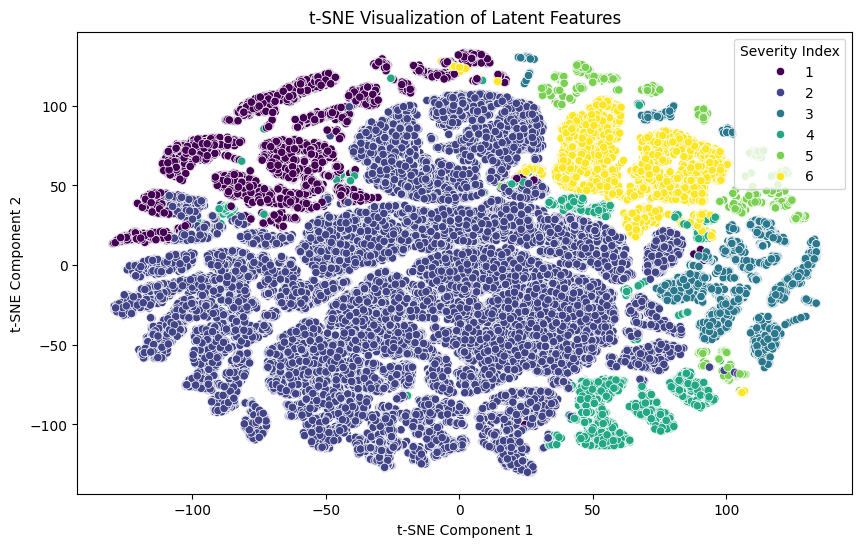

In [9]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(X_scaled)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title('t-SNE Visualization of Latent Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Severity Index')
plt.show()


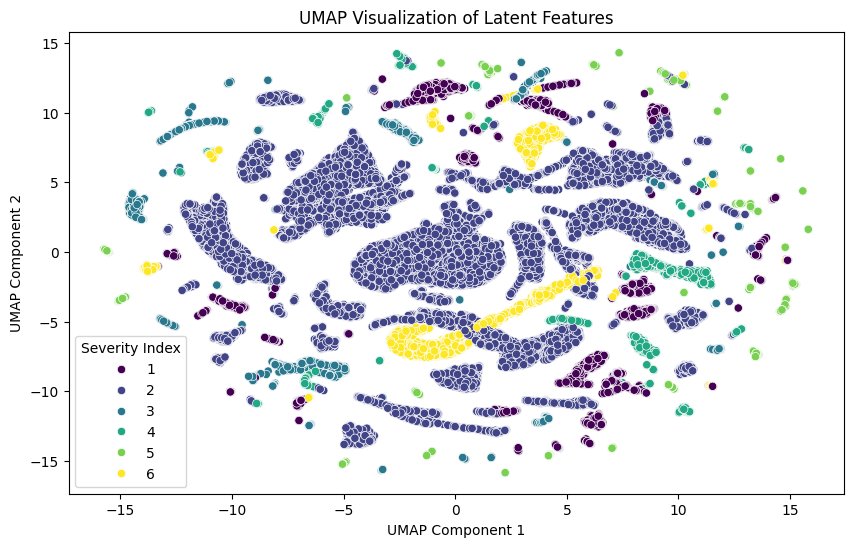

In [10]:
# UMAP Visualization
reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = reducer.fit_transform(X_scaled)

# Plot UMAP results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title('UMAP Visualization of Latent Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Severity Index')
plt.show()


In [ ]:
# Statistical Analysis
# ANOVA test to compare Predicted_Health_Index across clusters
anova_result = f_oneway(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
print(f"ANOVA F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")

# If data is not normally distributed, use Kruskal-Wallis test
kruskal_result = kruskal(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4e}")

# Cluster Profiles
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
# Remove 'Id' if it exists in the list
if 'Id' in numeric_columns:
    numeric_columns.remove('Id')
cluster_summary = data.groupby('Severity_Index')[numeric_columns].mean()
display(cluster_summary)


# Visualize Predicted Health Index by Severity Index
plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity_Index', y='Predicted_Health_Index', data=data)
plt.title('Predicted Health Index by Severity Index')
plt.xlabel('Severity Index')
plt.ylabel('Predicted Health Index')
plt.show()


In [12]:
# Save Analysis Results
data.to_csv('analysis_results.csv', index=False)
print("Analysis results saved.")

Analysis results saved.
